# Introduction

This notebook compares the test set performance of classifiers using term list scores based on the data-driven, RDoC, and DSM frameworks.

# Load the data

In [1]:
import pandas as pd
import numpy as np
np.random.seed(42)

import sys
sys.path.append("..")
import utilities

## Input parameters

In [2]:
metric = "mod" # Variable being compared between frameworks
n_iter = 1000 # Number of iterations for bootstrap distributions
frameworks = ["data-driven_k08", "data-driven", "rdoc", "dsm"]
clfs = ["_lr", "_lr", "", ""]
list_suffixes = ["", "", "_opsim", "_opsim"]
splits = ["discovery", "replication"]
suffix = "lr"

## Framework contents

In [3]:
lists, circuits = {}, {}
for fw, clf, list_suffix in zip(frameworks, clfs, list_suffixes):
    lists[fw], circuits[fw] = utilities.load_framework(fw, suffix=list_suffix, clf=clf)

## Observed values

In [4]:
obs = {}
for fw, clf in zip(frameworks, clfs):
    obs[fw] = pd.read_csv("data/{}_obs_{}{}.csv".format(metric, fw, clf), 
                                index_col=0, header=0)

In [5]:
obs["data-driven_k08"].loc[obs["data-driven_k08"]["SPLIT"] == "discovery"]["OBSERVED"].mean()

1.1262201849556965

In [6]:
obs["data-driven_k08"].loc[obs["data-driven_k08"]["SPLIT"] == "replication"]["OBSERVED"].mean()

1.1238086112402854

## Bootstrap distributions

In [7]:
boot, mean = {}, {}
for split in splits:
    boot[split], mean[split] = {}, {}
    for fw, clf in zip(frameworks, clfs):
        boot[split][fw] = pd.read_csv("data/{}_boot_{}{}_{}_{}iter.csv".format(metric, fw, clf, split, n_iter), 
                                index_col=0, header=0)
        mean[split][fw] = pd.read_csv("data/{}_mean_{}{}_{}.csv".format(metric, fw, clf, split), 
                                index_col=0, header=0)

In [8]:
boot["discovery"]["data-driven_k08"]

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
MEMORY,1.133967,1.125464,1.132936,1.136567,1.132965,1.132877,1.123142,1.139524,1.134523,1.133837,...,1.138006,1.139329,1.131046,1.128907,1.129654,1.131547,1.128489,1.130935,1.127810,1.130618
EMOTION,1.098426,1.093291,1.091083,1.095623,1.099124,1.093410,1.091833,1.101716,1.094737,1.099247,...,1.099527,1.093204,1.098758,1.097486,1.092460,1.097507,1.093404,1.096892,1.100595,1.088896
REWARD,1.098227,1.092478,1.099919,1.100046,1.092308,1.103549,1.096610,1.104123,1.110140,1.101268,...,1.092861,1.095397,1.091190,1.097021,1.098835,1.107211,1.102741,1.100285,1.101991,1.105076
COGNITION,1.037791,1.037920,1.039230,1.038085,1.039751,1.039232,1.039673,1.037501,1.038906,1.037818,...,1.038505,1.038105,1.038028,1.039010,1.038204,1.039146,1.037146,1.037953,1.038110,1.039468
VISION,1.107795,1.108107,1.104711,1.106386,1.106120,1.104797,1.105637,1.108842,1.106726,1.106491,...,1.107817,1.105633,1.108516,1.111819,1.107315,1.107682,1.107971,1.107207,1.110113,1.107176
MANIPULATION,1.189365,1.190294,1.189211,1.189794,1.189279,1.189430,1.189090,1.189533,1.189807,1.190079,...,1.189656,1.191695,1.191256,1.188494,1.190557,1.191163,1.190637,1.189221,1.189776,1.189796
LANGUAGE,1.131988,1.136235,1.138715,1.137630,1.138571,1.138373,1.140158,1.136912,1.138900,1.144834,...,1.133209,1.133075,1.141569,1.136630,1.138670,1.130794,1.137917,1.140072,1.134767,1.131435
HEARING,1.153798,1.164413,1.156360,1.159130,1.161793,1.168421,1.161406,1.168292,1.159459,1.159859,...,1.160464,1.155621,1.160137,1.156977,1.165089,1.161035,1.161500,1.164355,1.157348,1.159326


# Perform comparison tests

Is the mean of fw<sub>i</sub> greater than the mean of fw<sub>j</sub>?

In [9]:
from statsmodels.stats.multitest import multipletests

In [10]:
p, fdr = {}, {}
for split in splits:
    p[split] = np.empty((len(frameworks), len(frameworks)))
    for i, fw_i in enumerate(frameworks):
        for j, fw_j in enumerate(frameworks):
            boot_i = np.mean(boot[split][fw_i], axis=0)
            boot_j = np.mean(boot[split][fw_j], axis=0)
            p[split][i,j] = np.sum((boot_i - boot_j) <= 0.0) / float(n_iter)

    fdr[split] = multipletests(p[split].ravel(), method="fdr_bh")[1].reshape(p[split].shape)
    fdr[split] = pd.DataFrame(fdr[split], index=frameworks, columns=frameworks)
    
    print("-" * 65 + "\n" + split.upper() + "\n" + "-" * 65)
    print(fdr[split])
    print("")

-----------------------------------------------------------------
DISCOVERY
-----------------------------------------------------------------
                 data-driven_k08  data-driven  rdoc       dsm
data-driven_k08              1.0          0.0   0.0  0.000000
data-driven                  1.0          1.0   0.0  0.002667
rdoc                         1.0          1.0   1.0  1.000000
dsm                          1.0          1.0   0.0  1.000000

-----------------------------------------------------------------
REPLICATION
-----------------------------------------------------------------
                 data-driven_k08  data-driven  rdoc  dsm
data-driven_k08              1.0          0.0   0.0  0.0
data-driven                  1.0          1.0   0.0  1.0
rdoc                         1.0          1.0   1.0  1.0
dsm                          1.0          1.0   0.0  1.0



In [11]:
interval = 0.999
tail = (1.0 - interval) / 2.0 # Two-sided test
idx_lower = int(n_iter * tail)
idx_upper = int(n_iter * (1.0 - tail))

CI = {}
for split in splits:
    CI[split] = {}
    CI[split] = pd.DataFrame("", index=frameworks, columns=frameworks)
    for i, fw_i in enumerate(frameworks):
        for j, fw_j in enumerate(frameworks):
            boot_i = np.mean(boot[split][fw_i], axis=0)
            boot_j = np.mean(boot[split][fw_j], axis=0)
            boot_dif = np.sort(boot_i - boot_j)
            CI_lower = boot_dif[idx_lower]
            CI_upper = boot_dif[idx_upper]
            CI_sig = ""
            if (CI_lower > 0 and CI_upper > 0) or (CI_lower < 0 and CI_upper < 0):
                CI_sig = "*"
            CI[split].loc[fw_i,fw_j] = "{:.3f}, {:.3f} {}".format(CI_lower, CI_upper, CI_sig)
    
    print("-" * 65 + "\n" + split.upper() + "\n" + "-" * 65)
    print(CI[split])
    print("")

-----------------------------------------------------------------
DISCOVERY
-----------------------------------------------------------------
                  data-driven_k08       data-driven            rdoc  \
data-driven_k08     0.000, 0.000     0.015, 0.026 *  0.054, 0.063 *   
data-driven      -0.026, -0.015 *     0.000, 0.000   0.035, 0.042 *   
rdoc             -0.063, -0.054 *  -0.042, -0.035 *   0.000, 0.000    
dsm              -0.031, -0.020 *    -0.011, 0.000   0.027, 0.039 *   

                              dsm  
data-driven_k08    0.020, 0.031 *  
data-driven        -0.000, 0.011   
rdoc             -0.039, -0.027 *  
dsm                 0.000, 0.000   

-----------------------------------------------------------------
REPLICATION
-----------------------------------------------------------------
                  data-driven_k08       data-driven            rdoc  \
data-driven_k08     0.000, 0.000     0.016, 0.033 *  0.053, 0.069 *   
data-driven      -0.033, -0.016 *  

# Plot evaluation metrics

In [12]:
%matplotlib inline

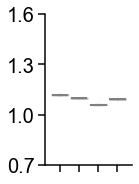

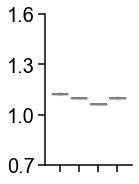

In [13]:
for split in splits:
    utilities.plot_framework_comparison(boot[split], obs, mean[split], metric=metric, w=1.2,
                                        n_iter=n_iter, suffix="k09_" + suffix + "_" + split, 
                                        ylim=[0.7,1.6], yticks=[0.7,1,1.3,1.6])